<a href="https://colab.research.google.com/github/Pinili/Deep-Learning-for-Satellite-Imagery/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated IAS identification approach using a Machine Learning approach

(Invasive alien species = IAS)

This is an independent thesis-project to classify <i>Rhamnus cathartica</i> using transfer learning in Convolutional Neural Networks (CNN).

All coding dependencies and datasets in this project is published under UWSpace with the original paper titled:
<br>__Identification of Invasive Plant Species using a Machine Learning approach__. 

In [1]:
## saves data on Google Drive + links to datasets
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
## install latest version, but will cause conflicting import errors with old fastai versions
 !curl -s https://course.fast.ai/setup/colab | bash

## uncomment to install old version of fastai
## !pip install fastai==0.7.0
## !pip install torchtext==0.2.3


Updating fastai...
Done.


In [3]:
## install extra dependencies
!pip install rasterio    #used for transform images into JPG format, when needed, and select bands
!pip install sat-search  #used to easily obtain Sentinel-2A data - Link: https://github.com/sat-utils

## install GDAL
!apt install gdal-bin python-gdal python3-gdal 

    100% |████████████████████████████████| 19.7MB 2.0MB/s 
    100% |████████████████████████████████| 61kB 7.5MB/s 
    100% |████████████████████████████████| 235kB 14.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/9c/59/4d/591519a4f416d5fc87b2823e424b7ec2930623b06c3e25e76e
  Stored in directory: /root/.cache/pip/wheels/be/8d/49/43673c9c16ce8427f1b3a9441cd751b07e25e099b59e01a8f4
Successfully built sat-search sat-stac
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninsta

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
## uncomment below to import fastai v0.7 packages instead
## from fastai.imports import *
## from fastai.conv_learner import *
## from fastai.model import *
## from fastai.plots import *


## import fastai v1 packages needed for image classification
from fastai.vision import *
from fastai.metrics import error_rate

## import rasterio + plotting
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

## import numpy
import numpy as np

## import GDAL
import gdal 

In [6]:
# show environment details
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.51
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Wed Apr 17 01:23:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+--

In [7]:
## list files and folders in the Google Drive connected
!ls "/content/gdrive/My Drive"


 _20120116134159_36913.zip
 2016_05_06_AHP_Template.gsheet
 Archive.zip
'BANFF Costs + Schedule.gsheet'
 CLEANSANITY
'Colab Notebooks'
'ENGL 109 - Ad Analysis - FFN Draft.gdoc'
'ENGL 109 - Argument Essay - FFN Draft.gdoc'
'ENVS 200 Final Exam Study Guide.gdoc'
'Exercise Log.gsheet'
 fastai-v3
'GEOG 203 Final Exam Study Questions 11:30pm.gdoc'
'GEOG 310 Lab #1 Dream Team.gdoc'
'GEOG 483 695 Group Project W17.gdoc'
'GEOG 483 695 Group Project W17 Rough Draft.gdoc'
'GEOG PLAN 381 Assignment #1 Write-up.gdoc'
'GEOG PLAN 381 Assignment #3 Write up.gdoc'
'GEOG PLAN 381 Assignment #4 Write up.gdoc'
'Girls Club Day 2'
'Irene vids'
 knob.jpg
'Lecture 23.pdf'
 LEL.txt
'Lifeguard Materials'
'main (1).pdf'
'main (2).pdf'
'main - Justin.pdf'
 main.pdf
'Markus Zusak - The Book Thief (Alfred A. Knopf - 2006).pdf'
'My map of the neighbourhood.gmap'
 Pictures
 Public
 resume-April2018.pdf
'School Work'
'SMS Backup'
'Statement of Interest (1).pdf'
'Statement of Interest.docx'
'Statement of Interest - Ju

In [0]:
## set main folder to the variable PATH as type Path
PATH = Path(base_dir + 'GEOG490data/')

## **Preprocessing**

#### Convert images to RGB and to .jpg format

In [28]:
#extract input folder data and class names
input_path = PATH/'input'
in_classes = [f for f in list(input_path.iterdir())]

#create new class directories in training folder
for i in in_classes:
  Path(PATH/'train'/os.path.basename(i)).mkdir(parents=True, exist_ok=False)

#convert Sentinel 13 bands .tiff files to RGB
for i in in_classes:
  print("Now converting class " + os.path.basename(i) + "...")
  in_files = list(i.iterdir())
  for f in in_files:
    out_class = os.path.basename(i)
    out_name = os.path.splitext(os.path.basename(f))[0]
    os.environ['f_in'] = str(f)
    os.environ['f_out'] = str(PATH/'train'/out_class/out_name)
    !gdal_translate -of JPEG -scale -b 4 -b 3 -b 2 "$f_in" "$f_out".jpg
    print("Converted: " + out_name)
    #gdal.TranslateOptions(format="GTiff", bandList=[4,3,2])
    #gdal.Translate(str(PATH/'train'/i/out_name), f)

Now converting class Highway...
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_2
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_6
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_4
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_7
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...7

## Visualization

#### Classes and Size

Highway class has 100
River class has 100
Residential class has 100
RhamnusCathartica class has 421


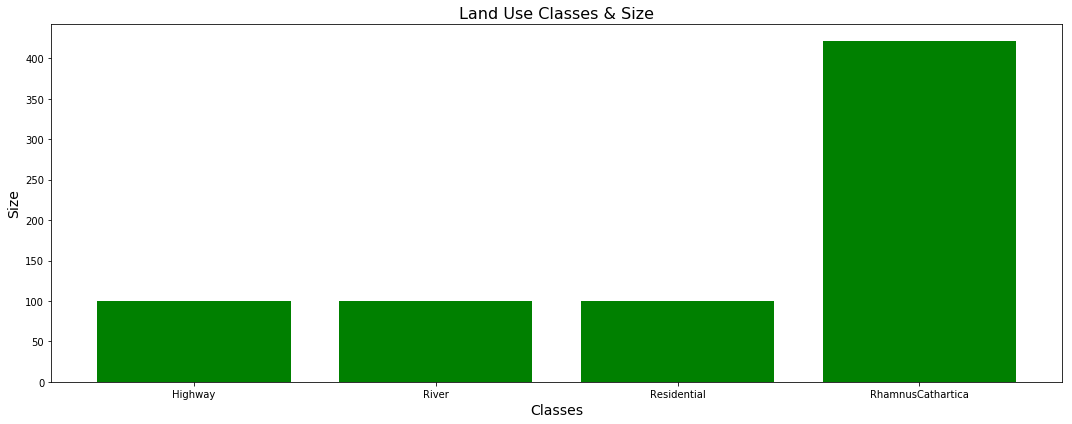

In [39]:
#extract training data and class names
train_path = PATH/'train'
classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

files = []
img_files = []
classes_num = {}
for i in classes:
    img_count = 0
    paths = train_path/i
    files.append(list(paths.iterdir())[0])
    for file in os.listdir(paths):
        if file.endswith(".jpg"):
            img_files.append(os.path.join(paths, file))
            img_count += 1
    classes_num[i] = img_count
    print(f'{i} class has ' + str(classes_num[i]))

    
plt.figure(figsize=(15,6))
plt.bar(classes_num.keys(), classes_num.values(), color='green')
plt.title('Land Use Classes & Size', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.tight_layout()
plt.savefig(PATH/'class_bargraph.jpg')

In [0]:
temp_dataset = rasterio.open(files[0])
temp_dataset.indexes

#### Images

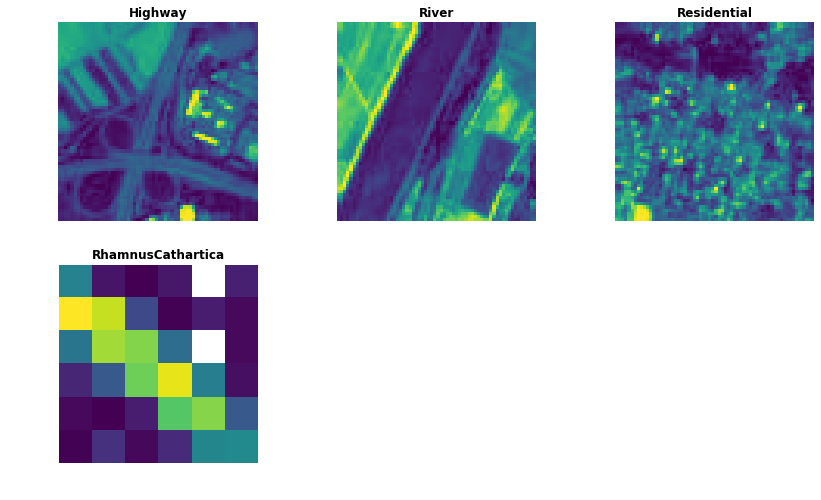

In [46]:
fig = plt.figure(figsize=(12,10))

# Open the file:
#fo = rasterio.open(files[0])

# Normalize bands into 0.0 - 1.0 scale
#def normalize(array):
#    array_min, array_max = array.min(), array.max()
#    return ((array - array_min)/(array_max - array_min))

#def raster_to_RGB(raster):
#  # Convert to numpy arrays
#  red = raster.read(4)
#  green = raster.read(3)
#  blue = raster.read(2)
#  # Normalize band DN
#  redn = normalize(red)
#  greenn = normalize(green)
#  bluen = normalize(blue)
#  # Stack bands
#  return np.dstack((redn, greenn, bluen))


#ax1 = plt.subplot(331);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[0])));ax1.set_title(classes[0], fontsize=14, fontweight='bold')
#ax2 = plt.subplot(332);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[1])));ax2.set_title(classes[1], fontsize=14, fontweight='bold')
#ax3 = plt.subplot(333);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[2])));ax3.set_title(classes[2], fontsize=14, fontweight='bold')
#ax1 = plt.subplot(334);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[3])));ax1.set_title(classes[3], fontsize=14, fontweight='bold')

ax1 = plt.subplot(331);plt.axis('off');plot.show(rasterio.open(files[0]), ax=ax1, title=classes[0])
ax2 = plt.subplot(332);plt.axis('off');plot.show(rasterio.open(files[1]), ax=ax2, title=classes[1])
ax3 = plt.subplot(333);plt.axis('off');plot.show(rasterio.open(files[2]), ax=ax3, title=classes[2])

ax1 = plt.subplot(334);plt.axis('off');plot.show(rasterio.open(files[3]), ax=ax1, title=classes[3])

#ax1 = plt.subplot(334);plt.axis('off');plot.show((rasterio.open(files[3]).read(4)), ax=ax1, title=classes[3])

plt.tight_layout()
plt.savefig(PATH/'class_sampleimg.jpg')

In [0]:
from rasterio.plot import show_hist


show_hist(rasterio.open(files[0]), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of " + classes[0])

## Model

In [49]:
#size of images
sz = 224
#architecture of machine learning used
arch=models.resnet50

train_in = str(PATH/"train")
print(train_in)


#il = ImageList.from_folder(PATH, convert_mode='L')
#sd = il.split_by_folder(train='train', valid='valid')
#sd = il.split_none()
#sd
#ll = sd.label_from_folder()
#ll

#data = ImageDataBunch.from_folder(train_in, 
#                                  train = 'train',
#                                  valid = 'valid',
#                                  size = 24)



tfms = get_transforms(do_flip=False)
data = (ImageList.from_folder(train_in)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch())

#tfms = get_transforms(do_flip=False)
#data = ImageDataBunch.from_folder(train_in, ds_tfms=tfms, size=24)

/content/gdrive/My Drive/fastai-v3/GEOG490data/train


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [58]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.808595,0.617454,0.201389,00:06
1,0.470316,0.318988,0.111111,00:06
2,0.321798,0.310306,0.062500,00:06
3,0.243954,0.252919,0.069444,00:07


In [0]:
lr = 1e-2

In [0]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [61]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='error_rate',
                                                 mode='min',
                                                 name='20190401-rn50class-stage1-best')
                    ]
                   )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


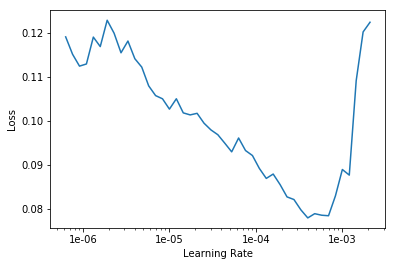

In [63]:
learn.recorder.plot_losses()

In [64]:
learn.load('20190107-rn50class-stage1-best')

epoch,train_loss,valid_loss,error_rate,time
0,0.085370,0.176877,0.048611,00:07
1,0.077634,0.149711,0.027778,00:08


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_top_losses(25, figsize=(20,15))

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

## Analyzing results & Visualization

In [0]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

### Invidual Predictions

In [0]:
classes_dict = dict(enumerate(data.classes))
classes_dict

In [0]:
fn = data.val_ds.fnames[0]
pic1 = rasterio.open(str(PATH/fn))
plt.axis('off')
plot.show(pic1)

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
print(classes_dict[np.argmax(preds)] == 'AnnualCrop')
np.argmax(preds), classes_dict[np.argmax(preds)]

In [0]:
data.val_ds.fnames[2900]

In [0]:
fn = data.val_ds.fnames[2900]
pic2 = rasterio.open(str(PATH/fn))
plt.axis('off')
plot.show(pic2)

In [0]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([2900]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
print(classes_dict[np.argmax(preds)] == 'Pasture')
np.argmax(preds), classes_dict[np.argmax(preds)]

### Confusion Matrix

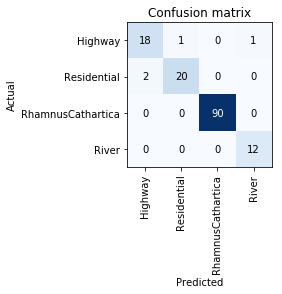

In [66]:
learn.load('stage-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [0]:
plot_confusion_matrix(cm, data.classes, cmap='Reds',figsize=(12,6))
plt.tight_layout()